# Segmentación y Preprocesamiento de Imágenes

Este notebook demuestra cómo realizar segmentación y preprocesamiento de imágenes utilizando Segment Anything y OpenCV. Cargaremos una imagen, generaremos una máscara para segmentar objetos del fondo y aplicaremos transparencia al fondo. Finalmente, la imagen procesada se guardará en formato PNG para preservar la transparencia.

### Conceptos Clave:
- **Segmentación de Imágenes**: El proceso de dividir una imagen digital en múltiples segmentos para simplificar o cambiar la representación de una imagen a algo más significativo.
- **Canal Alfa**: El canal de transparencia en una imagen. Las imágenes PNG lo utilizan para representar la transparencia.


Descargamos los checkpoints de Segment Anything:
- (https://github.com/facebookresearch/segment-anything#model-checkpoints)

Luego se lo tendremos que pasar a uno de sus métodos para que pueda instanciar el modelo

In [1]:
# importamos las librerias necesarias
import cv2
import io
import matplotlib.pyplot as plt
import numpy as np
import time
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

Nos cambiamos a la carpeta anterior, porque luego para estar manipulando las imágenes es mucho más fácil meternos a nivel de la carpeta "data"

In [3]:
import os

os.chdir("../")

In [4]:
# comprobamos en qué carpeta estamos

!pwd

/Users/marta.martinez/workspace/seminario/seminario-foundation-models


Establecemos los parámetros del modelo SAM así como la ruta de la imagen que queremos procesar

In [42]:
# parametros modelo
model_size = "small" # small, medium, large
device = "cpu" # cuda:0, cpu, mps

# ruta de la imagen
image_path = "data/charmander/00000014.jpg"
# data/bulbasaur/00000029.jpg
# data/pikachu/00000115.jpg

Cargamos el modelo en memoria

In [43]:
models_route = "model_checkpoints/"
# download model checkpoint (https://github.com/facebookresearch/segment-anything#model-checkpoints)
if(model_size == "small"):
    sam_checkpoint = models_route + "sam_vit_b_01ec64.pth"
    model_type = "vit_b"

if(model_size == "medium"):
    sam_checkpoint = models_route + "sam_vit_l_0b3195.pth"
    model_type = "vit_l"

if(model_size == "large"):
    sam_checkpoint = models_route + "sam_vit_h_4b8939.pth"
    model_type = "vit_h"

# load model and send to device
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


Cargamos la imagen, hay que cambiar la configuración de colores ya que opencv la carga en BGR y nosotros la queremos en RGB

In [44]:
# cargar imagen
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Ahora cargaremos el generador de máscaras de Segment Anything, le añadimos unas variables para que nos cronometre el tiempo que tarda en generar la máscara:

In [45]:
# instanciamos el generador de máscaras
mask_generator = SamAutomaticMaskGenerator(sam)

# obtenemos el tiempo de inicio
start = time.time()

# generamos la máscara
masks = mask_generator.generate(image)

# obtenemos el tiempo final
end = time.time()

print('Tiempo de procesado ' + str((end - start)) + ' s')

Tiempo de procesado 73.10983324050903 s


Una vez tenemos las máscaras generadas, es interesante poder verlas todas, para eso crearemos la siguiente función:

In [31]:
# función para obtener el plot de la imagen con las máscaras superpuestas
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

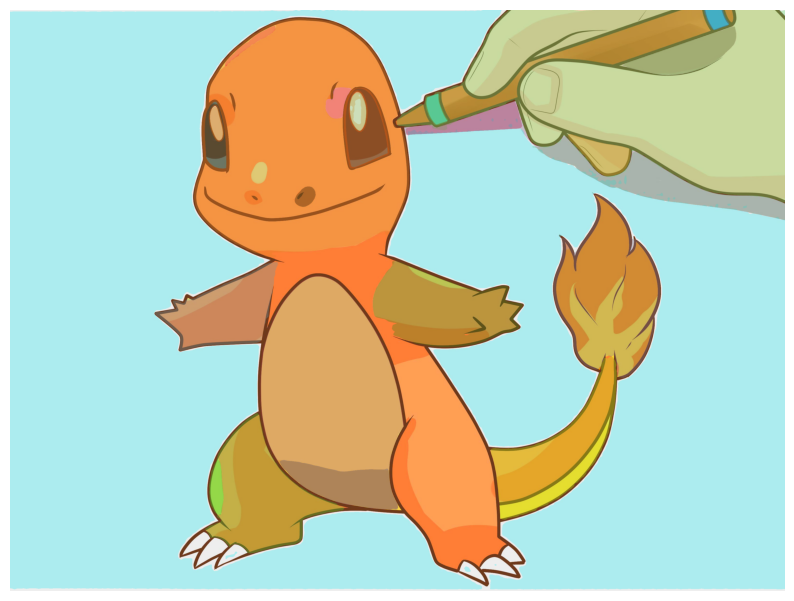

In [46]:
# ploteamos la imagen que cargamos en primer lugar, pero con las máscaras
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

En este caso no nos interesan todas las máscaras, solo aquella que marca el fondo. La lógica de este approach es bastante básico y no funcionará bien con todas las imáges, pero para hacerlo algo sencillo, vamos a suponer que la máscara que nos indica el fondo va a ser siempre la más grande.

La intención del siguiente código es definir una función que coja todas las máscaras y devuelva únicamente aquella más grande:

In [11]:
print(masks)

[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 4258779, 'bbox': [0, 0, 3199, 2393], 'predicted_iou': 1.0026203393936157, 'point_coords': [[150.0, 2287.5]], 'stability_score': 0.9504496455192566, 'crop_box': [0, 0, 3200, 2400]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 423763, 'bbox': [1033, 1099, 594, 965], 'predicted_iou': 0.995238184

In [12]:
def get_biggest_mask(masks):
    if len(masks) == 0:
        return None
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    return sorted_masks[0]

In [47]:
biggest_mask = get_biggest_mask(masks)
print(biggest_mask)

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 4258779, 'bbox': [0, 0, 3199, 2393], 'predicted_iou': 1.0026203393936157, 'point_coords': [[150.0, 2287.5]], 'stability_score': 0.9504496455192566, 'crop_box': [0, 0, 3200, 2400]}


Area -  4258779


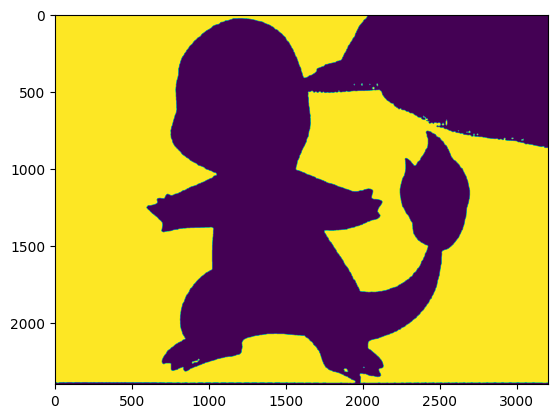

In [48]:
img_test=biggest_mask['segmentation']
print("Area - ",biggest_mask['area'])
plt.imshow(img_test)
plt.show()

Ya tenemos la imagen original, y la máscara que le queremos aplicar, recortemos la imagen:

In [49]:
#  Usamos formato PNG para que soporte transparencia
output_path = "./imagen_segmentada.png"
image = cv2.imread('data/charmander/00000014.jpg')

# Vamos a obtener esta máscara y nombrarla como el "fondo"
background = get_biggest_mask(masks)

# Nos quedamos con la parte del objeto mascara que nos interesa, la segmentación
segmentation = background['segmentation']

# Como la máscara señala el fondo, si la cogieramos como está nos quedaríamos solo con el fondo
# Justo lo contrario de lo que queremos, por lo que la invertimos
object_mask = np.invert(segmentation)

# Creamos una imagen vacía para luego rellenarla con los valores correctos
output_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)

# Copiamos los pixeles que nos interesan de la imagen original
output_image[:, :, :3] = image
# Marcammos el canal alfa a 255 en aquellos pixeles que pertenecen al objeto
output_image[:, :, 3] = object_mask.astype(np.uint8) * 255

# Guardamos el resultado
cv2.imwrite(output_path, output_image)
print(f"Imagen segmentada guardada en {output_path}")

Imagen segmentada guardada en ./imagen_segmentada.png
